# Bayesian Inference 1: Project Report

### Title: "The project title"

### Name: Antti Härkönen


## Abstract

> _Writing a short summary of your methods and the significant of your results, a succinct abstract is an art_

## Introduction

Introduce your dataset, then the related problem or the question, and the hypothesis for solving the issues.

Bonus point of your could provide short information of other approaches to the same problem

Introduce your method for building the model, short explain why given method is selected, what is it merits

Some text about the code packages you are going to use for the project (which language and libraries are used)

What is the goal you want to achieve after finishing the project

* Solving the specific problem
* Learn how to build probabilistic model for real world tasks
* ...

## Methods

Short description of which methods have been used for processing the data, building the model and doing the inference


### Dataset description and processing

What are the variables in the given dataset?

Are they random variable or deterministic variable? What are their distributions? 

What is the relation between the variable, 

* which one is observed ?
* which one is target variable ?
* which one is latent variable ?
* How all these variables could be linked to solve our problem ?

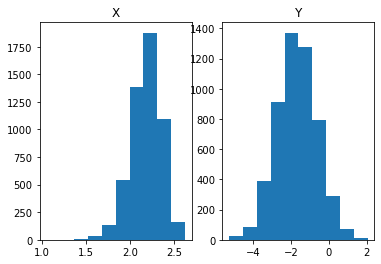

In [1]:
# plot the variable distribution with some preprocessing here to 
# support your assumption and hypothesis,  but don't be
# restricted to this code, you should think about relevant way
# of explaining your own hypothesis

# your code for building the model
# and doing the inference

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

data = gpd.read_file('spatial_income_1880.shp')
data['orthodox_proportion'] = data.orthodox_d / data.total_dens
data['income_per_person'] = data.total_inco / data.total_dens
data.income_per_person = data.income_per_person.apply(lambda w: w if 0 <= w <= 10 else np.nan)

for c in set(data.columns) - {'geometry', 'district', 'plot_numbe'}:
    data.plot(column=c, legend=True)
    plt.title(c)
    data.hist(c)

aspatial_data = pd.DataFrame(data, index=data.index)
aspatial_data['district_code'] = aspatial_data.district.factorize()[0]
aspatial_data.plot(x='income_per_person', y='orthodox_proportion', kind='scatter', c='district_code', colormap='viridis')
aspatial_data.to_csv('data.csv')


### Model description

Defining the generative process

Writing the pseudo-programme for generating the data, then visualizing it with graphical model

Specify all the distributions and their parameters

$O_{k}$: the proportion of Russian Orthodox population in location k

$W_{k}$: income per person in location k

$S$: the non-income-related segregation

$\bf\beta$ is the regression coefficient vector.

$ logit(\mu_k) = \beta_0 + \beta_1 W_k + \beta_2 S + \beta_3 W_k S $

$ \bf\beta \sim N(\mu_{\beta}, \sigma_{\beta}) $:

$ \bf\mu_{\beta} = \begin{pmatrix} 0 & 0 & 0 & 0 \end{pmatrix}' $

$ \bf\sigma_{\beta} = \begin{pmatrix} 0.2 & 0 & 0 & 0 \\ 0 & 0.2 & 0 & 0 \\ 0 & 0 & 0.2 & 0 \\ 0 & 0 & 0 & 0.2 \end{pmatrix} $

Write down the joint probability equation of the model


### Inference Method

Hamiltonian Monte Carlo is used to infer latent variables. The model is built using Python statistical inference library
[PyMC3](https://docs.pymc.io/) which implements (NUTS) NUTS is a gradient-based Monte Carlo method.

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, S]
Sampling 4 chains, 1 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 346.61draws/s]
The acceptance probability does not match the target. It is 0.8823333215919926, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 2000/2000 [00:02<00:00, 840.34it/s]
/home/antth/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/antth/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be 

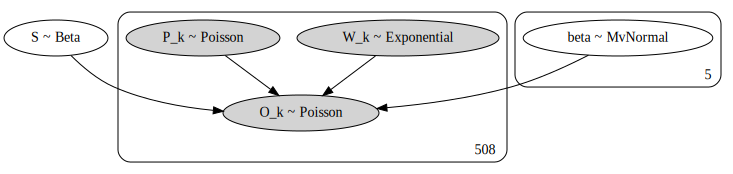

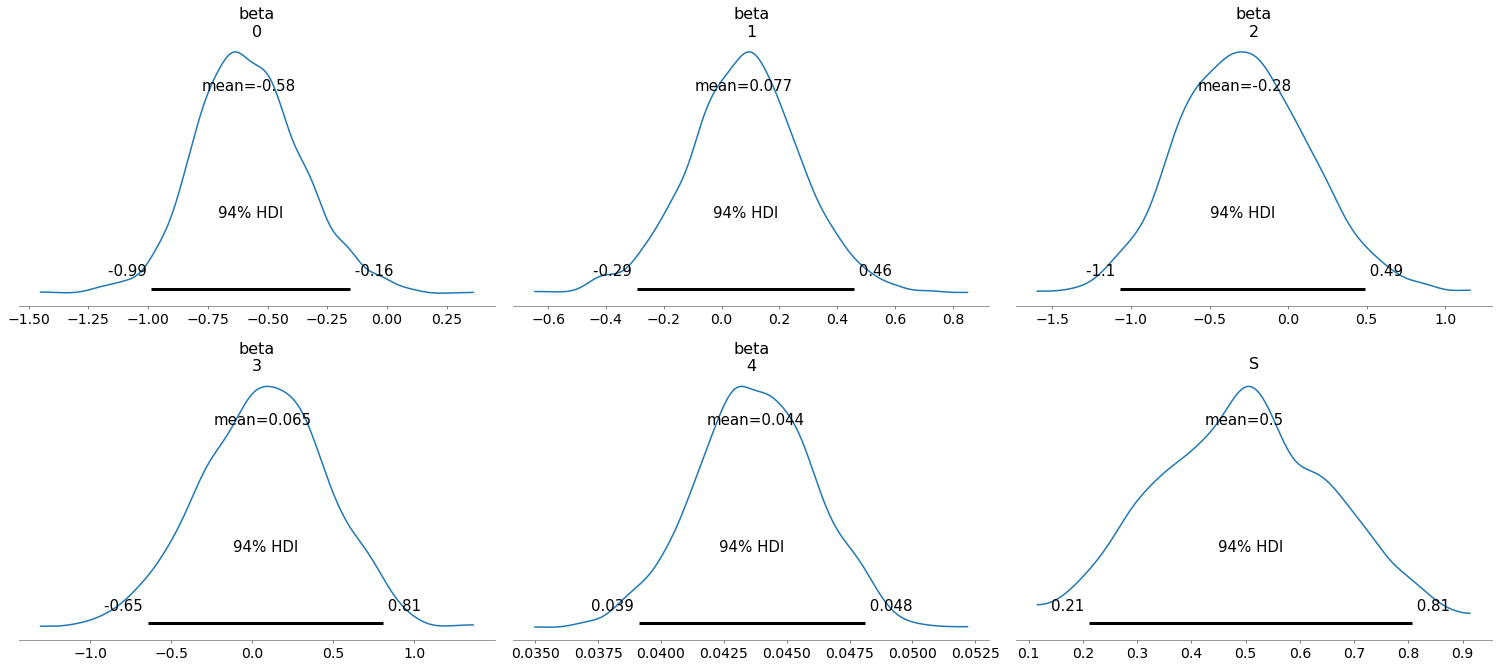

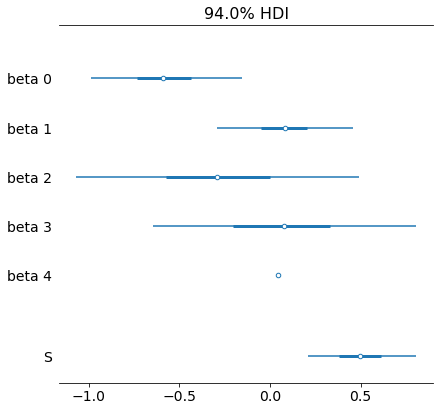

In [29]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
import arviz as az
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv', index_col=0)
data = data.loc[:, 'total orthodox income_per_person'.split()].dropna(axis=0)

with pm.Model() as model:
    alpha_S = 4
    beta_S = 4
    S = pm.Beta('S', alpha_S, beta_S)
    mu_W = 2
    lambda_W = 1/mu_W
    W_k = pm.Exponential('W_k', lambda_W, observed=data.income_per_person)
    mu_P = 14
    alpha_P = 2
    P_k = pm.Poisson('P_k', mu_P, observed=data.total)
    mu_beta = np.array([0., 0., 0., 0., 0.])
    sigma_beta = np.array(np.diagflat([0.2, 0.2, 0.2, 0.2, 0.2]))
    beta = pm.MvNormal('beta', mu_beta, sigma_beta, shape=5)
    mu_O = np.exp(beta[0] + beta[1] * W_k + beta[2] * S + beta[3] * W_k * S + beta[4] * P_k)
    alpha_O = 2
    O_k = pm.Poisson('O_k', mu_O, observed=data.orthodox)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample(init="adapt_diag")
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_forest(posterior, combined=True, hdi_prob=0.94)
pm.model_to_graphviz(model)

## Experiment

### Experiments setup

### Results

## Discussion and conclusion